## Sersic Image fitting using scipy and LMFIT
### Requeriments:
     - Scipy
     - Numpy
     - LMFIT
     - Pandas
   

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import morphen_decomposition
from morphen_decomposition import *
import astropy.io.fits as pf

import numpy as np
import lmfit
from lmfit import Model
from lmfit import Parameters, fit_report, minimize
import scipy
import time
import os

from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.stats import mad_std

from astropy import visualization
from astropy.visualization import simple_norm


def reset_rc_params():
    mpl.rcParams.update({'font.size': 14, 
        'mathtext.fontset': 'stix',
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.family": "sans",
        "font.serif": ["Exo 2"],
        "font.sans-serif": ["Exo 2"],
        'font.family': 'STIXGeneral', 
        'xtick.labelsize':16,
        'ytick.labelsize':16,
        'axes.labelsize' : 16,
        'xtick.major.width':1,
        'ytick.major.width':1,
        'axes.linewidth':1,
        'lines.linewidth':2,
        'legend.fontsize':14,
        "grid.linestyle":'--',                
        })
    pass
reset_rc_params()


                                                          ..___|**_
                                                  .|||||||||*+@+*__*++.
                                              _||||.           .*+;].,#_
                                         _|||*_                _    .@@@#@.
                                   _|||||_               .@##@#| _||_
         Morphen              |****_                   .@.,/\..@_.
                             #///#+++*|    .       .@@@;#.,.\@.
                              .||__|**|||||*||*+@#];_.  ;,;_
 Geferson Lucatelli                            +\*_.__|**#
                                              |..      .]]
                                               ;@       @.*.
                                                #|       _;]];|.
                                                 ]_          _+;]@.
                                                 _/_             |]\|    .  _
                                              ...._@* __ .

/home/sagauga/miniconda3/envs/numba/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# IMFIT_config_name = 'PGC0009514_r_imfit_2.conf' # 2 COMPONENTS
IMFIT_config_name = 'PGC0009514_r_imfit_1.conf' # 1 COMPONENT
imagename = 'PGC0009514_r_galnostars.fits'
data_2D = pf.getdata(imagename)
psf_name = 'psf_efigi_s13.fits'

######################################
"""
If you have a backgroud image, provide here.
I need to implement a automated way for that. 
In radio I do not use this, that is why I do not have. 
Though flat_sky used in the minimisation is 
flat_sky = mad_std(data_2D) which can be a good approximation.
"""
background = None 

In [3]:
imfit_conf_values,imfit_conf_names = read_imfit_params(IMFIT_config_name,return_names=True)
n_components = len(imfit_conf_values)-1 #last component is flat_SKY
print(' Imfit config values for ',imfit_conf_names)
print(imfit_conf_values)

 Imfit config values for  ['X0', 'Y0', 'PA', 'ell', 'n', 'I_e', 'R_e', 'I_sky']
[array([2.21e+02, 2.21e+02, 7.32e+01, 2.20e-01, 1.20e+00, 9.00e-01,
       6.35e+00]), array(0.001)]


In [4]:
imfit_conf_names

['X0', 'Y0', 'PA', 'ell', 'n', 'I_e', 'R_e', 'I_sky']

# Lets check if IMFIT config file  is ok, and we may be able to construct a LMFIT Model object from it

In [5]:
# this is just a helf-function, to check file and parameters
construct_model_parameters(imfit_conf_values[0:-1],
                           n_components=n_components,
                           init_params = 0.25,final_params = 4.0,constrained=False,fix_n=False)

Limiting  x0
{'f1_x0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f1_y0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f1_PA': {'value': 45, 'min': -50.0, 'max': 190}, 'f1_ell': {'value': 0.22, 'min': 0.001, 'max': 0.99}, 'f1_n': {'value': 0.5, 'min': 0.3, 'max': 5}, 'f1_In': {'value': 0.9, 'min': 1e-07, 'max': 10.0}, 'f1_Rn': {'value': 6.35, 'min': 0.5, 'max': 300.0}, 's_a': {'value': 2, 'min': -10.0, 'max': 50.0}}


(<lmfit.Model: (Model(sersic2D, prefix='f1_') + Model(FlatSky, prefix='s_'))>,
 Parameters([('f1_x0', <Parameter 'f1_x0', value=221.0, bounds=[171.0:271.0]>), ('f1_y0', <Parameter 'f1_y0', value=221.0, bounds=[171.0:271.0]>), ('f1_PA', <Parameter 'f1_PA', value=45, bounds=[-50.0:190]>), ('f1_ell', <Parameter 'f1_ell', value=0.22, bounds=[0.001:0.99]>), ('f1_n', <Parameter 'f1_n', value=0.5, bounds=[0.3:5]>), ('f1_In', <Parameter 'f1_In', value=0.9, bounds=[1e-07:10.0]>), ('f1_Rn', <Parameter 'f1_Rn', value=6.35, bounds=[0.5:300.0]>), ('s_a', <Parameter 's_a', value=2, bounds=[-10.0:50.0]>)]))

### What this means?
    fix_n = True
Is for radio images >> force a gaussian to be fitted to the image. 

#### If you have an optmized result from IMFIT (params file)
Or you made the config file by yourself and is confident that initial hits are good, you may use:<br>

    constrained = True
Then, parameters will bounded by `init_params = 0.25` and `final_params = 4.0`. For a simple example, limits for `Rn` will be `[0.25 * Rn_init,4.0 * Rn_init]` where `Rn_init` is the initial value from IMFIT config file (THIS APPLIES FOR ALL COMPONENTS).
#### If not, you must use:
    constrained = False
Paremeter space will be large, a standard minimization by Scipy/LMFIT

In [6]:
# do the actual fit
result_mini, mini,result_1,result_extra,model_dict, \
image_results_conv,image_results_deconv = do_fit2D(imagename=imagename,psf_name=psf_name,residualname=None,
                                        params_values_init = imfit_conf_values[0:-1],fix_n = False,
                                        ncomponents=n_components,constrained=False,
                                        method1 = 'least_squares',method2 = 'least_squares',
                                        init_params = 0.2,final_params = 6.0,save_name_append='_IMFIT_opt')

No residual/background provided. Setting 0.
Limiting  x0
{'f1_x0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f1_y0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f1_PA': {'value': 45, 'min': -50.0, 'max': 190}, 'f1_ell': {'value': 0.22, 'min': 0.001, 'max': 0.99}, 'f1_n': {'value': 0.5, 'min': 0.3, 'max': 5}, 'f1_In': {'value': 0.9, 'min': 1e-07, 'max': 10.0}, 'f1_Rn': {'value': 6.35, 'min': 0.5, 'max': 300.0}, 's_a': {'value': 2, 'min': -10.0, 'max': 50.0}}
 >> Using least_squares  solver for first optimisation run... 
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.6365e+02                                    9.88e+03    
       1              3         2.8054e+02      1.83e+02       7.99e+00       5.78e+02    
       2              4         2.2867e+02      5.19e+01       3.21e+00       4.18e+02    
       3              5         1.6310e+02      6.56e+01       8.69e+00       3.63e+02    
       4    

In [7]:
result_mini

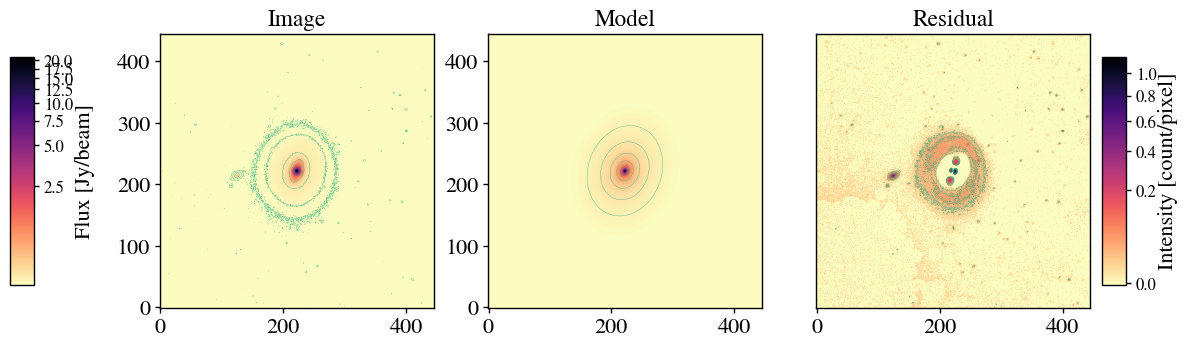

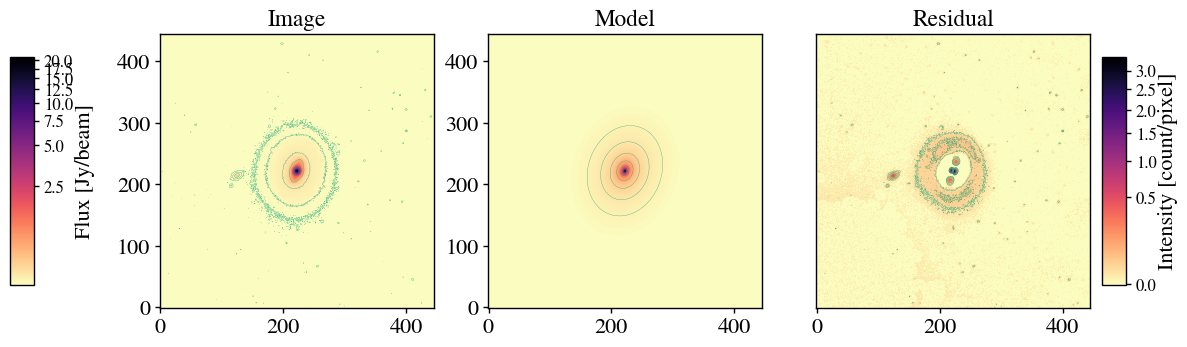

In [8]:
fast_plot3(ctn(imagename), modelname=model_dict['model_total_conv'],
           residualname=model_dict['best_residual_conv'], reference_image=imagename,
           NAME=IMFIT_config_name.replace('.conf',
                                   '_img'))
# plot non convolved results
fast_plot3(ctn(imagename), modelname=model_dict['model_total'],
           residualname=model_dict['best_residual'], reference_image=imagename,
           NAME=IMFIT_config_name.replace('.conf',
                                       '_dec_img'))

Peak Pos= (array([222]), array([222]))


/run/media/sagauga/storage_wd_2/cloud/onedirve_UoM/GitHubUoM/morphen/image_decomposition/morphen_decomposition.py:783: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
/tmp/ipykernel_26424/1723926749.py:35: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(1e-7,-2.5)


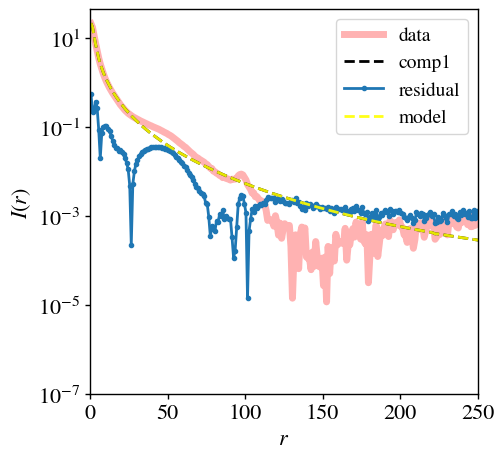

In [9]:
model_name = image_results_conv[-2]#crop_image.replace('.fits','')+"_"+str(ncomponents)+"C_model"+special_name+'_IMFIT_opt.fits'
residual_name = image_results_conv[-1]#crop_image.replace('.fits','')+"_"+str(ncomponents)+"C_residual"+special_name+'_IMFIT_opt.fits'

profile_data = {}
for i in range(n_components):
    component_name = image_results_conv[i]#crop_image.replace('.fits','')+"_"+str(ncomponents)+"C_model_component_"+str(i+1)+special_name+'_IMFIT_opt.fits'
    Ir_r = get_profile(component_name,
                       center=get_peak_pos(imagename))
    profile_data['r'+str(i+1)],profile_data['Ir'+str(i+1)],profile_data['c'+str(i+1)+'_name'] = Ir_r[0], Ir_r[1],component_name
r,ir = get_profile(imagename)
rmodel,irmodel = get_profile(model_name)
rre,irre = get_profile(residual_name)



# plt.plot(radiis[0],profiles[0])
# plt.plot(radiis[1],profiles[1])
# plt.plot(radiis[2],np.log(profiles[2]))
colors = ['black','purple','gray','red']
plt.figure(figsize=(5,5))
plt.plot(r,abs(ir),label='data',lw=5,color='red',alpha=0.3)
for i in range(n_components):
#     try:
#         plt.plot(profile_data['r'+str(i+1)],abs(profile_data['Ir'+str(i+1)])[0:r.shape[0]],'--',label='comp'+str(i+1),color=colors[i])
        plt.plot(profile_data['r'+str(i+1)],abs(profile_data['Ir'+str(i+1)]),'--',label='comp'+str(i+1),color=colors[i])
#     except:
#         pass

plt.plot(r,abs(irre)[0:r.shape[0]],'.-',label='residual')
plt.plot(r,abs(irmodel),'--',label='model',color='yellow',alpha=0.9)
plt.semilogy()
plt.xlabel(r'$r$')
plt.ylabel(r'$I(r)$ ')
plt.legend()
plt.ylim(1e-7,-2.5)
plt.xlim(0,250.0)
# plt.savefig(param_name.replace('params_imfit.csv','result_imfit_IR.pdf'),dpi=300, bbox_inches='tight')
plt.savefig(IMFIT_config_name.replace('.conf','result_lmfit_py_IR.pdf'),dpi=300, bbox_inches='tight')

# Try to model 2 components (bulge  + disk)

In [10]:
IMFIT_config_name = 'PGC0009514_r_imfit_2.conf' # 2 COMPONENTS
imfit_conf_values,imfit_conf_names = read_imfit_params(IMFIT_config_name,return_names=True)
n_components = len(imfit_conf_values)-1 #last component is flat_SKY
print(' Imfit config values for ',imfit_conf_names)
print(imfit_conf_values)

 Imfit config values for  ['X0', 'Y0', 'PA', 'ell', 'n', 'I_e', 'R_e', 'X0', 'Y0', 'PA', 'ell', 'n', 'I_e', 'R_e', 'I_sky']
[array([2.21e+02, 2.21e+02, 7.32e+01, 2.20e-01, 1.20e+00, 9.00e-01,
       6.35e+00]), array([2.21e+02, 2.21e+02, 7.32e+01, 2.20e-01, 8.40e-01, 2.90e-02,
       3.82e+01]), array(0.001)]


In [11]:
# do the actual fit
result_mini, mini,result_1,result_extra,model_dict, \
image_results_conv,image_results_deconv = do_fit2D(imagename=imagename,psf_name=psf_name,residualname=None,
                                        params_values_init = imfit_conf_values[0:-1],fix_n = False,
                                        ncomponents=n_components,constrained=False,
                                        method1 = 'least_squares',method2 = 'least_squares',
                                        init_params = 0.2,final_params = 6.0,save_name_append='_IMFIT_2_opt')

No residual/background provided. Setting 0.
Limiting  x0
Limiting  x0
{'f1_x0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f1_y0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f1_PA': {'value': 45, 'min': -50.0, 'max': 190}, 'f1_ell': {'value': 0.22, 'min': 0.001, 'max': 0.99}, 'f1_n': {'value': 0.5, 'min': 0.3, 'max': 5}, 'f1_In': {'value': 0.9, 'min': 1e-07, 'max': 10.0}, 'f1_Rn': {'value': 6.35, 'min': 0.5, 'max': 300.0}, 's_a': {'value': 2, 'min': -10.0, 'max': 50.0}, 'f2_x0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f2_y0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f2_PA': {'value': 45, 'min': -50.0, 'max': 190}, 'f2_ell': {'value': 0.22, 'min': 0.001, 'max': 0.99}, 'f2_n': {'value': 0.5, 'min': 0.3, 'max': 5}, 'f2_In': {'value': 0.029, 'min': 1e-07, 'max': 10.0}, 'f2_Rn': {'value': 38.2, 'min': 0.5, 'max': 300.0}}
 >> Using least_squares  solver for first optimisation run... 
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality 

In [12]:
result_mini

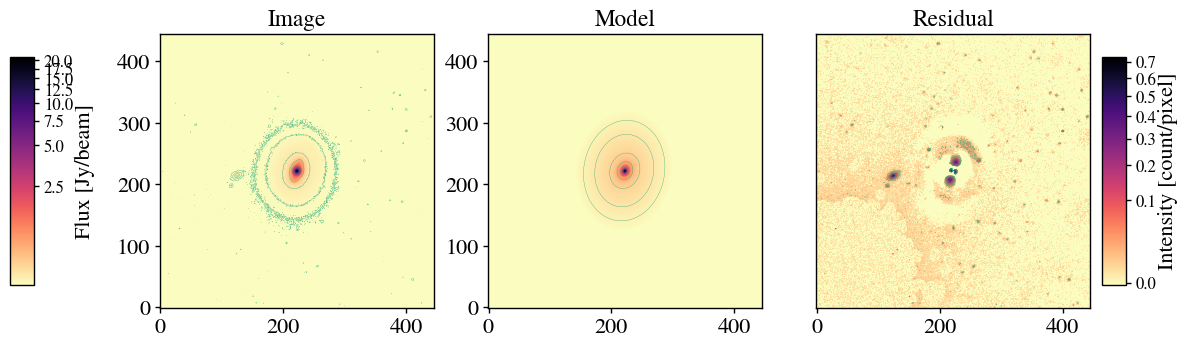

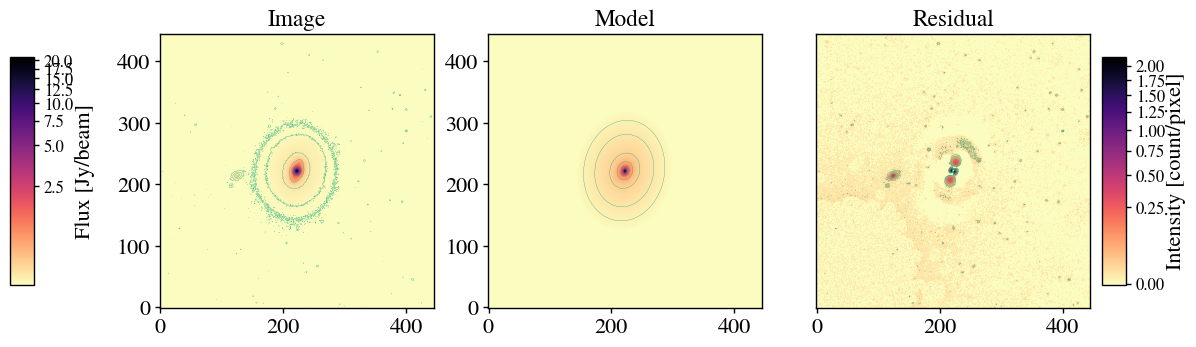

In [13]:
fast_plot3(ctn(imagename), modelname=model_dict['model_total_conv'],
           residualname=model_dict['best_residual_conv'], reference_image=imagename,
           NAME=IMFIT_config_name.replace('.conf',
                                   '_img'))
# plot non convolved results
fast_plot3(ctn(imagename), modelname=model_dict['model_total'],
           residualname=model_dict['best_residual'], reference_image=imagename,
           NAME=IMFIT_config_name.replace('.conf',
                                       '_dec_img'))

Peak Pos= (array([222]), array([222]))
Peak Pos= (array([222]), array([222]))


/run/media/sagauga/storage_wd_2/cloud/onedirve_UoM/GitHubUoM/morphen/image_decomposition/morphen_decomposition.py:783: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
/tmp/ipykernel_26424/4252301000.py:35: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(1e-7,-2.5)


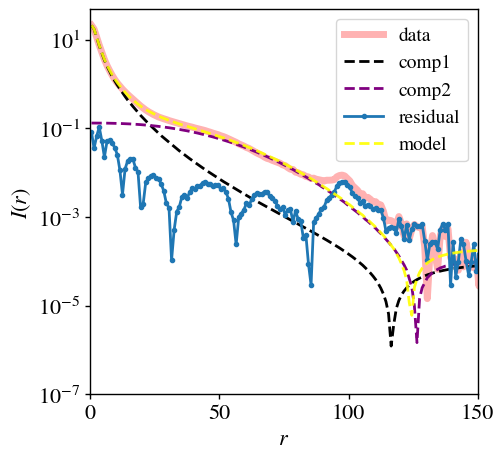

In [14]:
model_name = image_results_conv[-2]#crop_image.replace('.fits','')+"_"+str(ncomponents)+"C_model"+special_name+'_IMFIT_opt.fits'
residual_name = image_results_conv[-1]#crop_image.replace('.fits','')+"_"+str(ncomponents)+"C_residual"+special_name+'_IMFIT_opt.fits'

profile_data = {}
for i in range(n_components):
    component_name = image_results_conv[i]#crop_image.replace('.fits','')+"_"+str(ncomponents)+"C_model_component_"+str(i+1)+special_name+'_IMFIT_opt.fits'
    Ir_r = get_profile(component_name,
                       center=get_peak_pos(imagename))
    profile_data['r'+str(i+1)],profile_data['Ir'+str(i+1)],profile_data['c'+str(i+1)+'_name'] = Ir_r[0], Ir_r[1],component_name
r,ir = get_profile(imagename)
rmodel,irmodel = get_profile(model_name)
rre,irre = get_profile(residual_name)



# plt.plot(radiis[0],profiles[0])
# plt.plot(radiis[1],profiles[1])
# plt.plot(radiis[2],np.log(profiles[2]))
colors = ['black','purple','gray','red']
plt.figure(figsize=(5,5))
plt.plot(r,abs(ir),label='data',lw=5,color='red',alpha=0.3)
for i in range(n_components):
#     try:
#         plt.plot(profile_data['r'+str(i+1)],abs(profile_data['Ir'+str(i+1)])[0:r.shape[0]],'--',label='comp'+str(i+1),color=colors[i])
        plt.plot(profile_data['r'+str(i+1)],abs(profile_data['Ir'+str(i+1)]),'--',label='comp'+str(i+1),color=colors[i])
#     except:
#         pass

plt.plot(r,abs(irre)[0:r.shape[0]],'.-',label='residual')
plt.plot(r,abs(irmodel),'--',label='model',color='yellow',alpha=0.9)
plt.semilogy()
plt.xlabel(r'$r$')
plt.ylabel(r'$I(r)$ ')
plt.legend()
plt.ylim(1e-7,-2.5)
plt.xlim(0,150.0)
# plt.savefig(param_name.replace('params_imfit.csv','result_imfit_IR.pdf'),dpi=300, bbox_inches='tight')
plt.savefig(IMFIT_config_name.replace('.conf','result_lmfit_py_IR.pdf'),dpi=300, bbox_inches='tight')

# Try to model 3 components (bulge + bar + disk)

In [28]:
IMFIT_config_name = 'PGC0009514_r_imfit_3.conf' # 2 COMPONENTS
imfit_conf_values,imfit_conf_names = read_imfit_params(IMFIT_config_name,return_names=True)
n_components = len(imfit_conf_values)-1 #last component is flat_SKY
print(' Imfit config values for ',imfit_conf_names)
print(imfit_conf_values)

 Imfit config values for  ['X0', 'Y0', 'PA', 'ell', 'n', 'I_e', 'R_e', 'X0', 'Y0', 'PA', 'ell', 'n', 'I_e', 'R_e', 'X0', 'Y0', 'PA', 'ell', 'n', 'I_e', 'R_e', 'I_sky']
[array([2.21e+02, 2.21e+02, 7.32e+01, 2.20e-01, 1.20e+00, 9.00e-01,
       6.35e+00]), array([221.  , 221.  ,  73.2 ,   0.8 ,   0.5 ,   0.9 ,  30.35]), array([2.21e+02, 2.21e+02, 7.32e+01, 2.20e-01, 8.40e-01, 2.90e-02,
       3.82e+01]), array(0.1)]


In [29]:
# do the actual fit
result_mini, mini,result_1,result_extra,model_dict, \
image_results_conv,image_results_deconv = do_fit2D(imagename=imagename,psf_name=psf_name,residualname=None,
                                        params_values_init = imfit_conf_values[0:-1],fix_n = False,
                                        ncomponents=n_components,constrained=False,
                                        method1 = 'least_squares',method2 = 'least_squares',
                                        init_params = 0.2,final_params = 6.0,save_name_append='_IMFIT_3_opt')

No residual/background provided. Setting 0.
Limiting  x0
Limiting  x0
Limiting  x0
{'f1_x0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f1_y0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f1_PA': {'value': 45, 'min': -50.0, 'max': 190}, 'f1_ell': {'value': 0.22, 'min': 0.001, 'max': 0.99}, 'f1_n': {'value': 0.5, 'min': 0.3, 'max': 5}, 'f1_In': {'value': 0.9, 'min': 1e-07, 'max': 10.0}, 'f1_Rn': {'value': 6.35, 'min': 0.5, 'max': 300.0}, 's_a': {'value': 2, 'min': -10.0, 'max': 50.0}, 'f2_x0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f2_y0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f2_PA': {'value': 45, 'min': -50.0, 'max': 190}, 'f2_ell': {'value': 0.8, 'min': 0.001, 'max': 0.99}, 'f2_n': {'value': 0.5, 'min': 0.3, 'max': 5}, 'f2_In': {'value': 0.9, 'min': 1e-07, 'max': 10.0}, 'f2_Rn': {'value': 30.35, 'min': 0.5, 'max': 300.0}, 'f3_x0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f3_y0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f3_PA': {'value': 45, 'min': 

In [33]:
result_mini

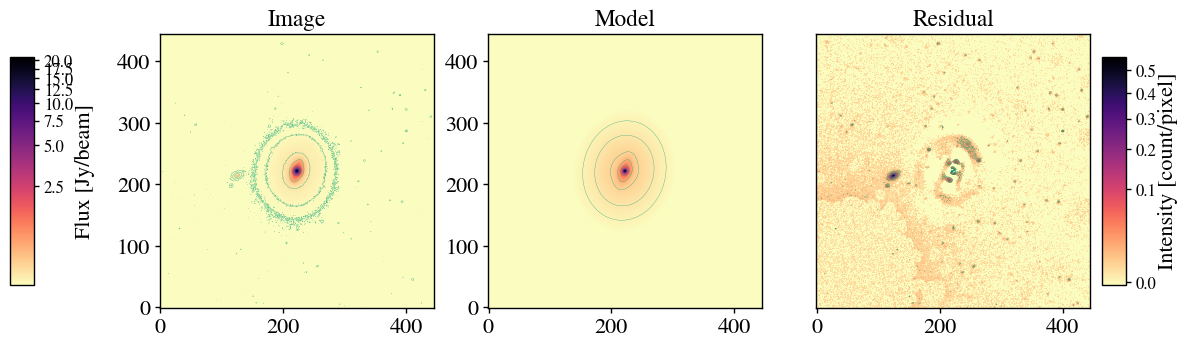

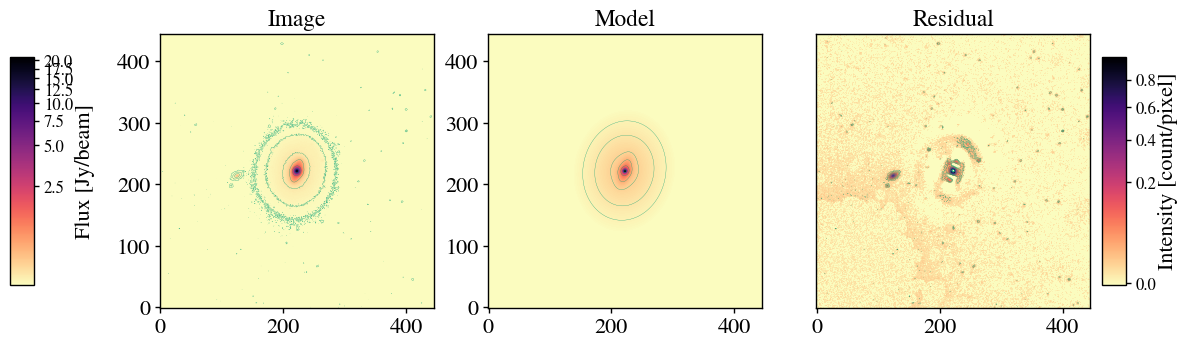

In [34]:
fast_plot3(ctn(imagename), modelname=model_dict['model_total_conv'],
           residualname=model_dict['best_residual_conv'], reference_image=imagename,
           NAME=IMFIT_config_name.replace('.conf',
                                   '_img'))
# plot non convolved results
fast_plot3(ctn(imagename), modelname=model_dict['model_total'],
           residualname=model_dict['best_residual'], reference_image=imagename,
           NAME=IMFIT_config_name.replace('.conf',
                                       '_dec_img'))

Peak Pos= (array([222]), array([222]))
Peak Pos= (array([222]), array([222]))
Peak Pos= (array([222]), array([222]))


/run/media/sagauga/storage_wd_2/cloud/onedirve_UoM/GitHubUoM/morphen/image_decomposition/morphen_decomposition.py:783: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
/tmp/ipykernel_26424/4252301000.py:35: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(1e-7,-2.5)


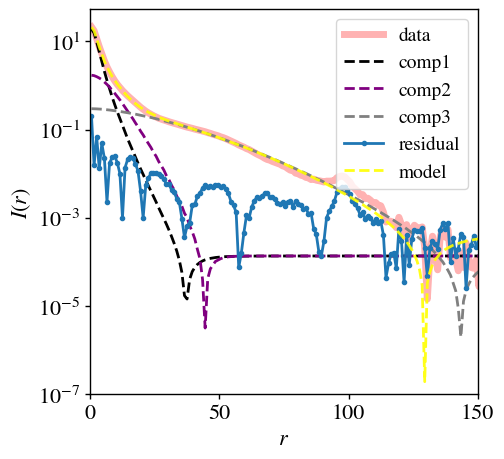

In [35]:
model_name = image_results_conv[-2]#crop_image.replace('.fits','')+"_"+str(ncomponents)+"C_model"+special_name+'_IMFIT_opt.fits'
residual_name = image_results_conv[-1]#crop_image.replace('.fits','')+"_"+str(ncomponents)+"C_residual"+special_name+'_IMFIT_opt.fits'

profile_data = {}
for i in range(n_components):
    component_name = image_results_conv[i]#crop_image.replace('.fits','')+"_"+str(ncomponents)+"C_model_component_"+str(i+1)+special_name+'_IMFIT_opt.fits'
    Ir_r = get_profile(component_name,
                       center=get_peak_pos(imagename))
    profile_data['r'+str(i+1)],profile_data['Ir'+str(i+1)],profile_data['c'+str(i+1)+'_name'] = Ir_r[0], Ir_r[1],component_name
r,ir = get_profile(imagename)
rmodel,irmodel = get_profile(model_name)
rre,irre = get_profile(residual_name)



# plt.plot(radiis[0],profiles[0])
# plt.plot(radiis[1],profiles[1])
# plt.plot(radiis[2],np.log(profiles[2]))
colors = ['black','purple','gray','red']
plt.figure(figsize=(5,5))
plt.plot(r,abs(ir),label='data',lw=5,color='red',alpha=0.3)
for i in range(n_components):
#     try:
#         plt.plot(profile_data['r'+str(i+1)],abs(profile_data['Ir'+str(i+1)])[0:r.shape[0]],'--',label='comp'+str(i+1),color=colors[i])
        plt.plot(profile_data['r'+str(i+1)],abs(profile_data['Ir'+str(i+1)]),'--',label='comp'+str(i+1),color=colors[i])
#     except:
#         pass

plt.plot(r,abs(irre)[0:r.shape[0]],'.-',label='residual')
plt.plot(r,abs(irmodel),'--',label='model',color='yellow',alpha=0.9)
plt.semilogy()
plt.xlabel(r'$r$')
plt.ylabel(r'$I(r)$ ')
plt.legend()
plt.ylim(1e-7,-2.5)
plt.xlim(0,150.0)
# plt.savefig(param_name.replace('params_imfit.csv','result_imfit_IR.pdf'),dpi=300, bbox_inches='tight')
plt.savefig(IMFIT_config_name.replace('.conf','result_lmfit_py_IR.pdf'),dpi=300, bbox_inches='tight')

### Use nelder-mead as first opt run

In [ ]:
# do the actual fit
result_mini, mini,result_1,result_extra,model_dict, \
image_results_conv,image_results_deconv = do_fit2D(imagename=imagename,psf_name=psf_name,residualname=None,
                                        params_values_init = imfit_conf_values[0:-1],fix_n = False,
                                        ncomponents=n_components,constrained=False,
                                        method1 = 'nelder',method2 = 'least_squares',
                                        init_params = 0.2,final_params = 6.0,save_name_append='_IMFIT_3_opt')

No residual/background provided. Setting 0.
Limiting  x0
Limiting  x0
Limiting  x0
{'f1_x0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f1_y0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f1_PA': {'value': 45, 'min': -50.0, 'max': 190}, 'f1_ell': {'value': 0.22, 'min': 0.001, 'max': 0.99}, 'f1_n': {'value': 0.5, 'min': 0.3, 'max': 5}, 'f1_In': {'value': 0.9, 'min': 1e-07, 'max': 10.0}, 'f1_Rn': {'value': 6.35, 'min': 0.5, 'max': 300.0}, 's_a': {'value': 2, 'min': -10.0, 'max': 50.0}, 'f2_x0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f2_y0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f2_PA': {'value': 45, 'min': -50.0, 'max': 190}, 'f2_ell': {'value': 0.8, 'min': 0.001, 'max': 0.99}, 'f2_n': {'value': 0.5, 'min': 0.3, 'max': 5}, 'f2_In': {'value': 0.9, 'min': 1e-07, 'max': 10.0}, 'f2_Rn': {'value': 30.35, 'min': 0.5, 'max': 300.0}, 'f3_x0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f3_y0': {'value': 221.0, 'min': 171.0, 'max': 271.0}, 'f3_PA': {'value': 45, 'min': 

In [ ]:
result_mini

In [ ]:
fast_plot3(ctn(imagename), modelname=model_dict['model_total_conv'],
           residualname=model_dict['best_residual_conv'], reference_image=imagename,
           NAME=IMFIT_config_name.replace('.conf',
                                   '_img'))
# plot non convolved results
fast_plot3(ctn(imagename), modelname=model_dict['model_total'],
           residualname=model_dict['best_residual'], reference_image=imagename,
           NAME=IMFIT_config_name.replace('.conf',
                                       '_dec_img'))

In [ ]:
model_name = image_results_conv[-2]#crop_image.replace('.fits','')+"_"+str(ncomponents)+"C_model"+special_name+'_IMFIT_opt.fits'
residual_name = image_results_conv[-1]#crop_image.replace('.fits','')+"_"+str(ncomponents)+"C_residual"+special_name+'_IMFIT_opt.fits'

profile_data = {}
for i in range(n_components):
    component_name = image_results_conv[i]#crop_image.replace('.fits','')+"_"+str(ncomponents)+"C_model_component_"+str(i+1)+special_name+'_IMFIT_opt.fits'
    Ir_r = get_profile(component_name,
                       center=get_peak_pos(imagename))
    profile_data['r'+str(i+1)],profile_data['Ir'+str(i+1)],profile_data['c'+str(i+1)+'_name'] = Ir_r[0], Ir_r[1],component_name
r,ir = get_profile(imagename)
rmodel,irmodel = get_profile(model_name)
rre,irre = get_profile(residual_name)



# plt.plot(radiis[0],profiles[0])
# plt.plot(radiis[1],profiles[1])
# plt.plot(radiis[2],np.log(profiles[2]))
colors = ['black','purple','gray','red']
plt.figure(figsize=(5,5))
plt.plot(r,abs(ir),label='data',lw=5,color='red',alpha=0.3)
for i in range(n_components):
#     try:
#         plt.plot(profile_data['r'+str(i+1)],abs(profile_data['Ir'+str(i+1)])[0:r.shape[0]],'--',label='comp'+str(i+1),color=colors[i])
        plt.plot(profile_data['r'+str(i+1)],abs(profile_data['Ir'+str(i+1)]),'--',label='comp'+str(i+1),color=colors[i])
#     except:
#         pass

plt.plot(r,abs(irre)[0:r.shape[0]],'.-',label='residual')
plt.plot(r,abs(irmodel),'--',label='model',color='yellow',alpha=0.9)
plt.semilogy()
plt.xlabel(r'$r$')
plt.ylabel(r'$I(r)$ ')
plt.legend()
plt.ylim(1e-7,-2.5)
plt.xlim(0,150.0)
# plt.savefig(param_name.replace('params_imfit.csv','result_imfit_IR.pdf'),dpi=300, bbox_inches='tight')
plt.savefig(IMFIT_config_name.replace('.conf','result_lmfit_py_IR.pdf'),dpi=300, bbox_inches='tight')